In [4]:
from scipy.io import loadmat
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def show(x):
    imgplot = plt.imshow(x)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def load_data(mat_path):
    d = loadmat(mat_path)

    return d["image"], d["gender"][0], d["age"][0], d["db"][0], d["img_size"][0, 0], d["min_score"][0, 0]

In [5]:
length = 0
for i in range(9):
    length += len(load_data('../wiki/wiki-part{}.mat'.format(i))[0])
with open('../sorted_faces/train/train_info.txt') as f:
    for i, l in enumerate(f):
        pass
    length += i + 1

print(length)

43390


In [6]:
# You need 12GB to create these memmaps
X_train = np.memmap('../Dataset/training_images', dtype='uint8', mode='w+', shape=(length, 299, 299, 3))
gender_train = np.memmap('../Dataset/training_genders', dtype='uint8', mode='w+', shape=(length))
age_train = np.memmap('../Dataset/training_ages', dtype='uint8', mode='w+', shape=(length))

In [7]:
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

j = 0

for i in range(9):
    image, gender, age, _, _, _ = load_data('../wiki/wiki-part{}.mat'.format(i))
    X_train[j : j + len(image)] = [cv2.cvtColor(x, cv2.COLOR_BGR2RGB) for x in image]
    gender_train[j : j + len(image)] = [(y + 1) % 2 for y in gender]
    age_train[j : j + len(image)] = age[:]
    j += len(image)

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
with open('../sorted_faces/train/train_info.txt') as f:
    gender_dict = {'m': 0, 'f' : 1}
    for i, line in enumerate(f):
        img_name, gender, age = line.split(' ; ')
        img = load_img('../sorted_faces/train/all/{}'.format(img_name), target_size=(299, 299))
        X_train[j + i] = img_to_array(img)
        gender_train[j + i] = gender_dict[gender]
        
        age = eval(age)
        # If age is not well labelised (None in dataset), it takes the value 255
        if not age:
            age = 255
        if type(age) == tuple:
            age = np.mean(age)
        age_train[j + i] = int(age)

In [9]:
X_train

memmap([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ..., 
          [ 87,  90,  99],
          [ 90,  93, 102],
          [ 93,  96, 105]],

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ..., 
          [ 86,  89,  98],
          [ 89,  92, 101],
          [ 94,  97, 106]],

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ..., 
          [ 85,  89,  97],
          [ 89,  92, 101],
          [ 95,  98, 106]],

         ..., 
         [[ 45,  82, 135],
          [ 35,  72, 125],
          [ 29,  66, 119],
          ..., 
          [ 16,  80, 143],
          [ 19,  79, 144],
          [ 29,  75, 143]],

         [[ 42,  79, 131],
          [ 33,  70, 123],
          [ 27,  64, 117],
          ..., 
          [ 19,  80, 144],
          [ 22,  79, 145],
          [ 32,  79, 146]],

         [[ 41,  76, 130],
          [ 40,  75, 129],
          [ 35,  70, 124],
    

### show 10 random images from the memmaps

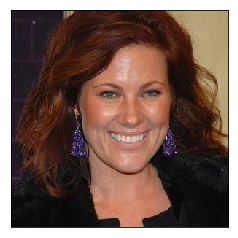

1
36


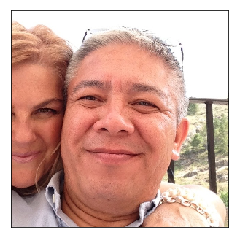

0
55


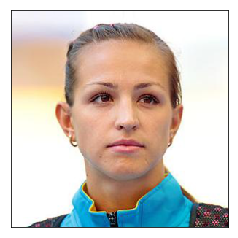

1
26


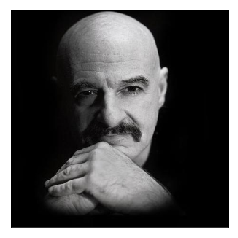

0
61


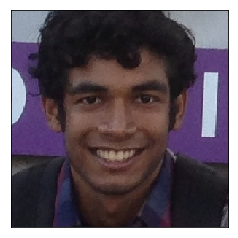

0
17


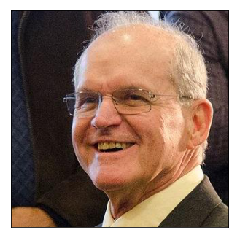

0
75


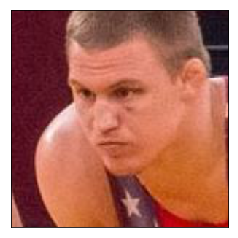

0
26


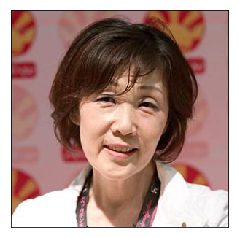

1
63


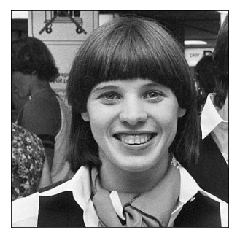

1
20


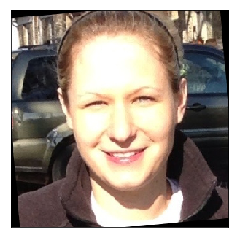

1
28


In [10]:
for i in [np.random.randint(0, length) for _ in range(10)]:
    show(X_train[i])
    print(gender_train[i])
    print(age_train[i])

### Randomize memmaps

In [13]:
from tempfile import mkdtemp
import os.path as path

filename1 = path.join(mkdtemp(), 'newfile1.dat')
filename2 = path.join(mkdtemp(), 'newfile2.dat')
filename3 = path.join(mkdtemp(), 'newfile3.dat')

X_temp = np.memmap(filename1, dtype='uint8', mode='w+', shape=(length, 299, 299, 3))
gender_temp = np.memmap(filename2, dtype='uint8', mode='w+', shape=(length))
age_temp = np.memmap(filename3, dtype='uint8', mode='w+', shape=(length))

shuffled_indices = np.random.permutation(length)

batch_size = length // 20
for i in range(20):
    if i < 19:
        X_temp[batch_size * i : batch_size * (i+1)] = X_train[shuffled_indices[batch_size * i : batch_size * (i+1)]]
        gender_temp[batch_size * i : batch_size * (i+1)] = gender_train[shuffled_indices[batch_size * i : batch_size * (i+1)]]
        age_temp[batch_size * i : batch_size * (i+1)] = age_train[shuffled_indices[batch_size * i : batch_size * (i+1)]]
    else:
        X_temp[batch_size * i :] = X_train[shuffled_indices[batch_size * i :]]
        gender_temp[batch_size * i :] = gender_train[shuffled_indices[batch_size * i :]]
        age_temp[batch_size * i :] = age_train[shuffled_indices[batch_size * i :]]

for i in range(20):
    if i < 19:
        X_train[batch_size * i : batch_size * (i+1)] = X_temp[batch_size * i : batch_size * (i+1)] 
        gender_train[batch_size * i : batch_size * (i+1)] = gender_temp[batch_size * i : batch_size * (i+1)]
        age_train[batch_size * i : batch_size * (i+1)] = age_temp[batch_size * i : batch_size * (i+1)]
    else:
        X_train[batch_size * i :] = X_temp[batch_size * i :]
        gender_train[batch_size * i :] = gender_temp[batch_size * i :]
        age_train[batch_size * i :] = age_temp[batch_size * i :]

del X_temp
del gender_temp
del age_temp

In [16]:
print(X_train)
print(gender_train)
print(age_train)

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ..., 
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ..., 
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ..., 
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ..., 
  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ..., 
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ..., 
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ..., 
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[ 37  27  18]
   [ 37  27  18]
   [ 38  27  21]
   ..., 
   [231 202 132]
   [237 207 137]
   [231 201 131]]

  [[ 38  28  19]
   [ 32  22  13]
   [ 41  31  22]
   ..., 
   [229 200 130]
   [232 202 132]
   [229 199 129]]

  [[ 41  31  21]
   [ 34  24  15]
   [ 33  23  14]
   ..., 
   [228 199 129]
   [229 2

### show 10 random images from the randomized memmaps

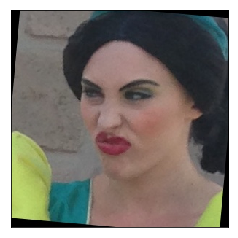

1
28


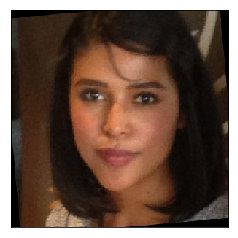

1
28


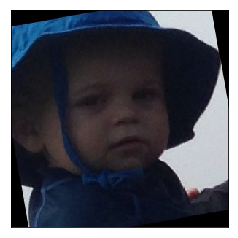

0
3


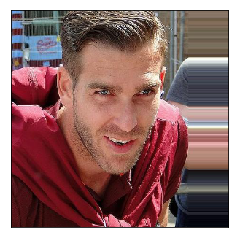

0
28


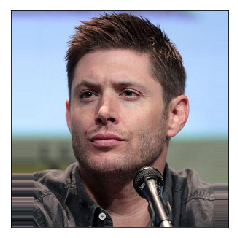

0
37


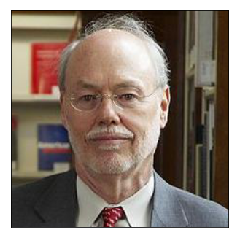

0
63


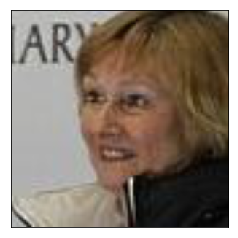

1
62


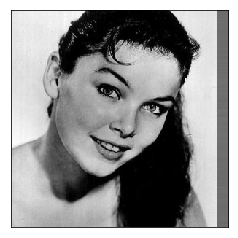

1
23


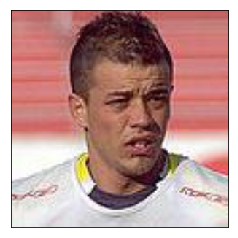

0
27


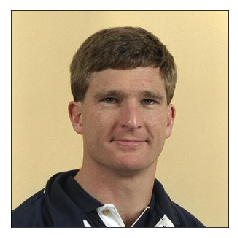

0
35


In [18]:
for i in [np.random.randint(0, length) for _ in range(10)]:
    show(X_train[i])
    print(gender_train[i])
    print(age_train[i])